In [1]:


import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, in_channels=4):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # assuming 64x64 patches
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 32, 32, 32]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 64, 16, 16]
        x = x.view(x.size(0), -1)             # flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x)  # return logits (no sigmoid)

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN()  # or whatever your model class is
state_dict = torch.load(r"C:\Users\mayer\Работен плот\final forest detector\WeightsProbe.pth", map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.eval()


SimpleCNN(
  (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [4]:
def predict(model, image_path):
    # Detect file type
    if image_path.endswith('.npy'):
        array = np.load(image_path)  # shape: [H, W, 15]
        red = array[:, :, 3] / 10000.0
        green = array[:, :, 2] / 10000.0
        blue = array[:, :, 1] / 10000.0
        ndvi = array[:, :, 13]

        # Stack to [4, H, W]
        stacked = np.stack([red, green, blue, ndvi], axis=0)
    elif image_path.endswith('.png') or image_path.endswith('.jpg'):
        img = Image.open(image_path).convert('RGB')
        img = img.resize((64, 64))  # Resize for consistency
        img = np.array(img).astype(np.float32) / 255.0

        red = img[:, :, 0]
        green = img[:, :, 1]
        blue = img[:, :, 2]
        ndvi = np.zeros_like(red)

        # Stack to [4, 64, 64]
        stacked = np.stack([red, green, blue, ndvi], axis=0)

    elif image_path.endswith('.tif') or image_path.endswith('.tiff'):
        import rasterio
        with rasterio.open(image_path) as src:
        # Read bands using Sentinel-2 standard band numbers:
        # Band 4 = red (index 4)
        # Band 3 = green (index 3)
        # Band 2 = blue (index 2)
        # Band 8 = NIR (index 8)
         red = src.read(4).astype(np.float32) / 10000.0
         green = src.read(3).astype(np.float32) / 10000.0
         blue = src.read(2).astype(np.float32) / 10000.0
         nir = src.read(8).astype(np.float32) / 10000.0

        # Compute NDVI
         ndvi = (nir - red) / (nir + red + 1e-5)

        # Stack to [4, H, W]
         stacked = np.stack([red, green, blue, ndvi], axis=0)
    else:
        raise ValueError("Unsupported file format. Use .npy or .png/.jpg")

    # Resize if needed (for .npy)
    if stacked.shape[1:] != (64, 64):
        tensor = torch.tensor(stacked, dtype=torch.float32).unsqueeze(0)  # [1, 4, H, W]
        tensor = F.interpolate(tensor, size=(64, 64), mode='bilinear', align_corners=False)
    else:
        tensor = torch.tensor(stacked, dtype=torch.float32).unsqueeze(0)

    # Predict
    model.eval()
    device = next(model.parameters()).device
    with torch.no_grad():
        logit = model(tensor.to(device))
        prob = torch.sigmoid(logit).item()
        label = "VEGETATION" if prob > 0.5 else "NO_VEGETATION"
   
   # visualize = true 
    import matplotlib.pyplot as plt

    rgb_vis = np.stack([red, green, blue], axis=-1)
    rgb_vis = np.clip(rgb_vis, 0, 1)
    plt.figure(figsize=(4, 4))
    plt.imshow(rgb_vis)
    plt.title(f"Prediction: {label}", fontsize=14, color='green' if label == "VEGETATION" else 'red')
    plt.axis('off')
    plt.show()
  

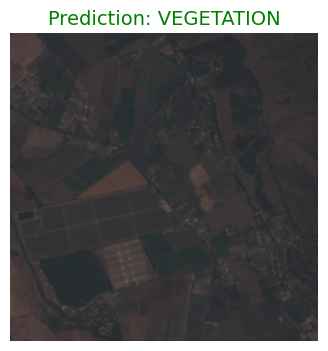

None


In [8]:
import zipfile
import os
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt


import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import rasterio 
# CUSTOM DATASET
import rasterio
import json
from tqdm import tqdm
#loads the data from the BigEarthNet dataset, which is the strangly configurated one 
import pandas as pd
import pyarrow
import fastparquet

import pyarrow as pa
import pyarrow.parquet as pq

testFile_path = r"C:\Users\mayer\Работен плот\final forest detector\sample_veg_detection_data\NO_VEGETATION\chile_tile_(2304, 9472).npy" # Get the uploaded filename
result = predict(model, testFile_path)
print(result)